In [51]:
import chess.pgn
import chess.svg
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
from src import core
import analysis
import importlib
importlib.reload(analysis)
importlib.reload(core)
plt.style.use('dark_background')

In [55]:
pgn = open("data/lichess.pgn")
data = []
for i in range(200):
	game = core.ChessGame(chess.pgn.read_game(pgn), 'Ax_6')
	data += game.evaluate_moves([
		core.Blunder, 
		core.Mistake,
		core.Inaccuracy,
		core.TopMove,
		core.OutcomeProbability,
		core.PieceSacrifice])
df = pd.DataFrame(data)

In [56]:
df['time_from_midnight'] = df['date'] - df['date'].dt.normalize()
# Sort df chronologically
df = df.sort_values(['date', 'half_move_number']).reset_index()

sel_my_moves = df['is_my_move']
sel_my_blunders = sel_my_moves & df['is_blunder']
sel_piece_sacrifice = df['is_piece_sacrifice']

fdf = df[sel_my_moves]

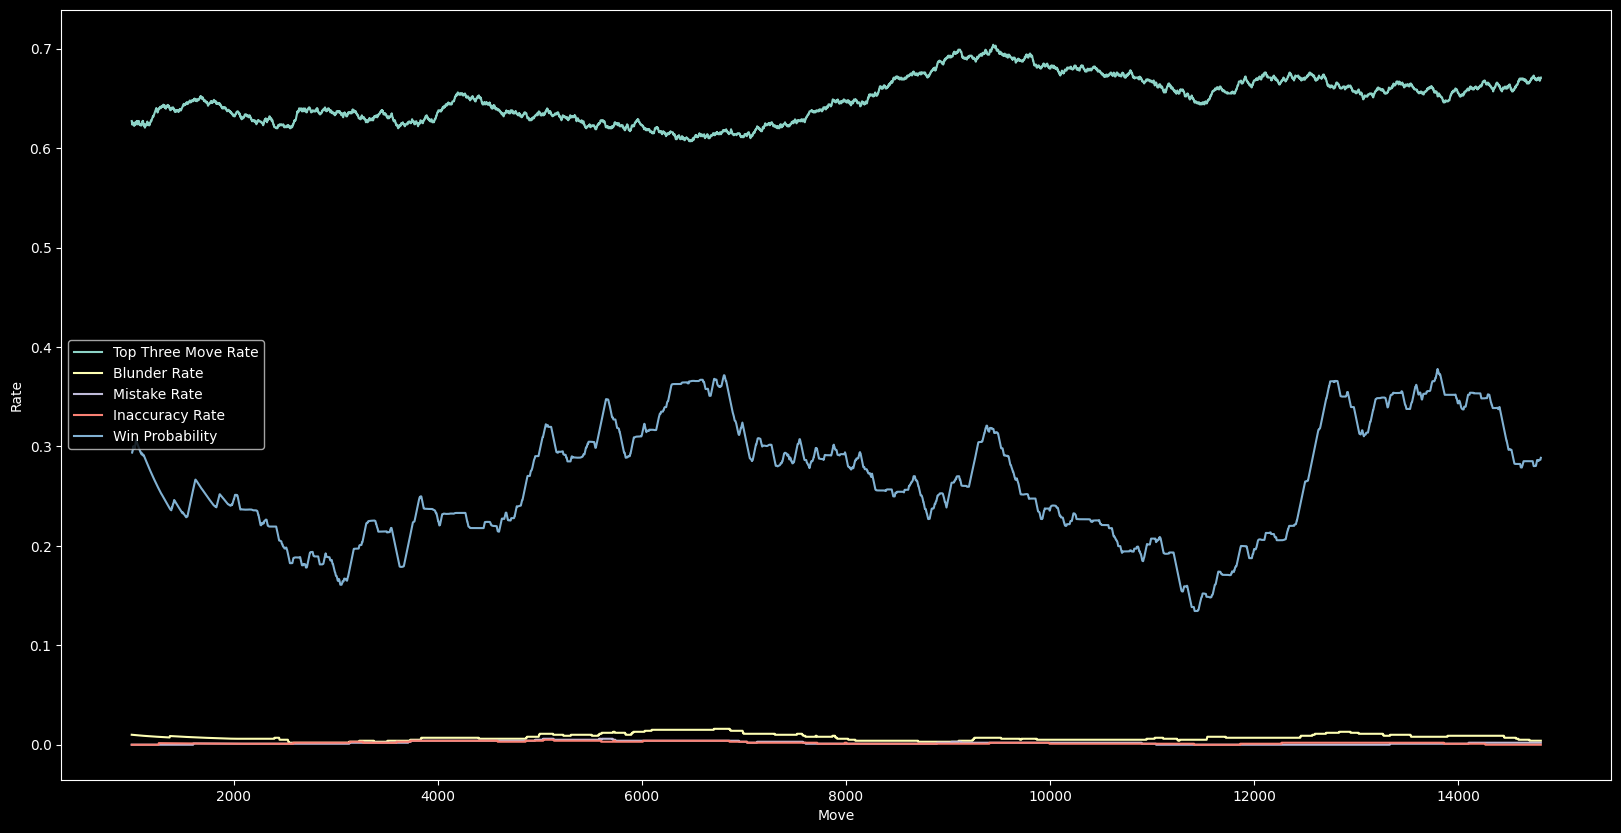

In [58]:
# We want to calculate the rolling average of the
# blunder rate, best move, top three move and top five move.
# Rolling window defined as a constant
ROLLING_AVERAGE_WINDOW = 1000

# date / is_blunder, is_best_move, is_top_three_move, is_top_five_move
rolling_average = fdf[[
	'is_blunder',
	'is_top_move',
	'is_top_three_move', 
	'is_top_five_move',
	'is_inaccuracy', 
	'is_mistake',
	'win_probability',
	'draw_probability',
	'lose_probability'
]].rolling(window=ROLLING_AVERAGE_WINDOW, min_periods=int((ROLLING_AVERAGE_WINDOW - 1) / 2)).mean()

# Plot the rolling average
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(rolling_average['is_top_three_move'], label='Top Three Move Rate')
ax.plot(rolling_average['is_blunder'], label='Blunder Rate')
ax.plot(rolling_average['is_mistake'], label='Mistake Rate')
ax.plot(rolling_average['is_inaccuracy'], label='Inaccuracy Rate')
ax.plot(rolling_average['win_probability'] / 1000, label='Win Probability')
ax.set_xlabel('Move')
ax.set_ylabel('Rate')
ax.legend()

plt.show()

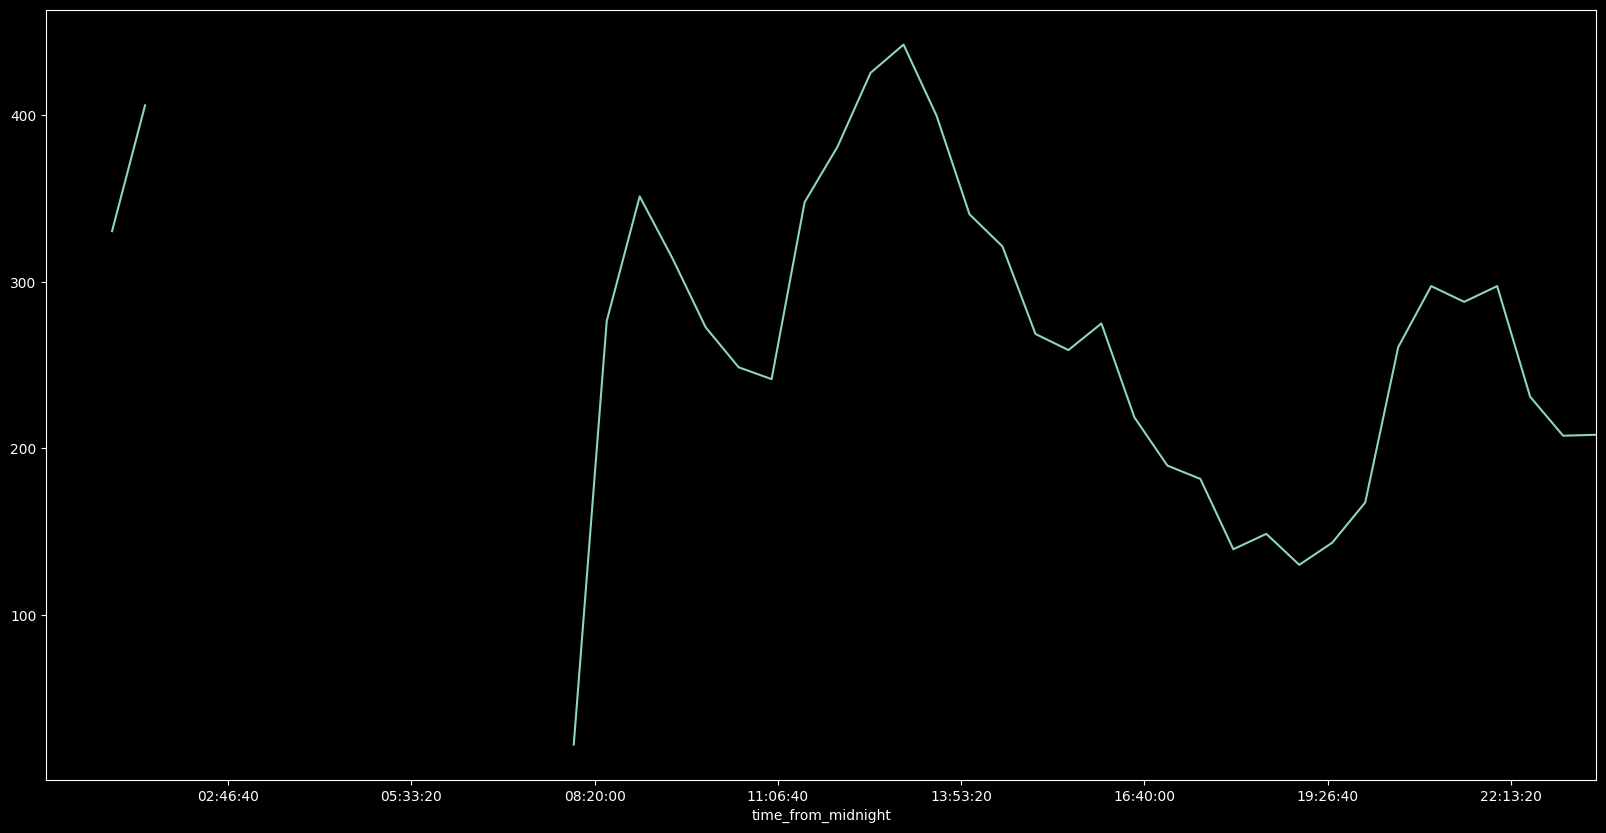

In [102]:
from datetime import timedelta

ROLLING_TOD_WINDOW = timedelta(minutes=120)
filtered = fdf.sort_values('time_from_midnight').set_index('time_from_midnight')['win_probability'].rolling(ROLLING_TOD_WINDOW).mean()
grouped = filtered.groupby(pd.Grouper(freq='30Min')).mean()

# Plot the rolling average
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
grouped.plot(ax=ax)
plt.show()

In [81]:
grouped

time_from_midnight
0 days 00:01:00     74.000000
0 days 00:01:00     37.000000
0 days 00:01:00     40.666667
0 days 00:01:00    272.750000
0 days 00:01:00    418.200000
                      ...    
0 days 23:56:46    201.306502
0 days 23:56:46    201.195876
0 days 23:56:46    201.242019
0 days 23:56:46    201.111111
0 days 23:56:46    200.904419
Name: win_probability, Length: 7404, dtype: float64

In [46]:
df

,date,half_move_number,move_number,move,eval,is_my_move,is_blunder,is_mistake,is_inaccuracy,is_top_move,is_top_three_move,is_top_five_move,win_probability,draw_probability,lose_probability,is_piece_sacrifice,piece_sacrificed
0,2024-03-17 10:16:11,1,1,d2d4,0.27,False,False,False,False,False,True,True,13.0,907.0,80.0,False,None
1,2024-03-17 10:16:11,2,2,g8f6,0.33,True,False,False,False,False,False,False,11.0,894.0,95.0,False,None
2,2024-03-17 10:16:11,3,2,h2h4,-0.23,False,False,False,False,False,False,False,87.0,901.0,12.0,False,None
3,2024-03-17 10:16:11,4,3,e7e6,-0.24,True,False,False,False,False,False,False,81.0,906.0,13.0,False,None
4,2024-03-17 10:16:11,5,3,f2f3,-1.24,False,False,False,False,False,False,False,742.0,258.0,0.0,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7413,2024-02-25 22:06:19,53,27,h2g3,3.78,True,True,False,False,False,False,False,1000.0,0.0,0.0,False,None
7414,2024-02-25 22:06:19,54,28,f8c8,5.59,False,False,False,False,False,False,False,1000.0,0.0,0.0,False,None
7415,2024-02-25 22:06:19,55,28,c1c8,5.63,True,True,False,False,False,False,False,1000.0,0.0,0.0,False,None
7416,2024-02-25 22:06:19,56,29,e6c8,5.68,False,False,False,False,False,False,False,1000.0,0.0,0.0,False,None
